In [1]:
import zipfile

import numpy as np
import pandas as pd
from scipy.sparse import diags, csr_matrix, isspmatrix
from scipy.sparse.linalg import svds
from tqdm import tqdm
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import scipy.sparse as sp
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse.linalg import spsolve

from dataprep import transform_indices, reindex_data, generate_interactions_matrix
from evaluation import downvote_seen_items, topn_recommendations
from sklearn.metrics.pairwise import cosine_similarity

# getting data from Kaggle

In [2]:
competition_name = "skoltech-recommender-systems-challenge-2023"

In [3]:
!kaggle competitions download -c {competition_name}

skoltech-recommender-systems-challenge-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile("skoltech-recommender-systems-challenge-2023.zip","r") as z:
    z.extractall(".")

In [5]:
training_source = pd.read_csv('training')

In [6]:
testset_source = pd.read_csv('testset')

# Convenience functions

In [7]:
def plot_monthly_activity(data, ax=None, label=None, timeid='timestamp'):
    return (data
        .set_index(pd.to_datetime(data[timeid], unit='s'))
        .resample('M').size()
        .plot(ax=ax, logy=True, label=label, xlabel='Month',
              title='Monthly rating activity', legend=label is not None)
    )

## data splitting

In [8]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.movieid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and movieid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

## kaggle solution format

In [9]:
def save_solution(recs_array, useridx, itemidx, filepath):
    """
    Save a solution for Kaggle competition in the required format.

    Parameters 
    ----------
    recs_array (numpy.ndarray): Array of recommended items. 
    useridx (pandas.Index): Test user indices in the original (source) representation. 
    itemidx (pandas.Index): Mapping from internal to orignial representation of item indices. 
    filepath (str): Path to save the solution file. 

    Returns
    -------
    None: The function saves the solution file in the csv format at the specified path. 

    Notes
    -----
    The code creates a dataframe containing user IDs and a list of recommended items for each user.
    It then melts the dataframe so that each row contains one recommended item per user.
    Finally, it saves the melted dataframe to a file at the specified filepath.
    """
    rec_items = itemidx.take(recs_array).values
    solution = pd.DataFrame({
        'userid': useridx,
        'movieid': [list(recs) for recs in rec_items]
    })
    sol_melt = solution.set_index('userid')['movieid'].explode().reset_index()
    sol_melt.to_csv(filepath, index=False)

To submit a solution, you can use he following command directly from a notebook cell:  

```
!kaggle competitions submit -c {competition_name} -f {filepath} -m 'my new submission'
```

<Axes: title={'center': 'Monthly rating activity'}, xlabel='Month'>

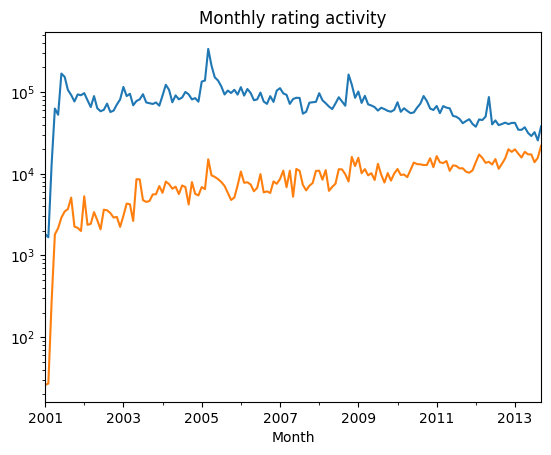

In [10]:
plot_monthly_activity(training_source)
plot_monthly_activity(testset_source)

# Evaluation setup

In [11]:
topn = 20

In [12]:
def evaluate(recommended_items, holdout, holdout_description, topn=20):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # NDCG calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    ndcg_pu = 1.0 / np.log2(hit_rank + 1)
    ndcg = np.sum(ndcg_pu) / n_test_users
    return ndcg

# 50 pts baseline

In [13]:
def transform_data(train, test, holdout=None, userid='userid', itemid='movieid'):
    training, data_index = transform_indices(train, userid, itemid)
    testset = reindex_data(test, data_index, fields='items')
    if holdout is None:
        return training, testset, data_index
    holdout = reindex_data(holdout, data_index, fields='items')
    assert not holdout['movieid'].eq(-1).any()
    return training, testset, holdout, data_index

In [14]:
training_, testset_, holdout_ = timepoint_split(training_source)
training, testset, holdout, data_index = transform_data(training_, testset_, holdout_)
assert not holdout['movieid'].eq(-1).any()

In [15]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    test_users = holdout[data_index['users'].name].values
)

In [16]:
training_final, testset_final, data_index_source = transform_data(training_source, testset_source)

In [17]:
data_description_source = dict(
    users = data_index_source['users'].name,
    items = data_index_source['items'].name,
    feedback = 'rating',
    n_users = len(data_index_source['users']),
    n_items = len(data_index_source['items']),
    test_users = holdout[data_index_source['users'].name].values
)

In [18]:
test_users_index = pd.Index(
    testset_source['userid'].drop_duplicates()
)
test_users_index

Int64Index([    55,    133,    136,    213,    539,    604,    718,   1029,
              1088,   1179,
            ...
            282326, 282382, 282402, 282420, 282522, 282663, 282836, 282999,
            283047, 283183],
           dtype='int64', name='userid', length=2963)

### grid-search

In [19]:
ranks = [b*2**n for n in range(3, 9) for b in [2, 3]]
ranks

[16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [20]:
def svd_model_scoring(params, data, data_description):
    item_factors = params
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = source_matrix.dot(item_factors) @ item_factors.T
    downvote_seen_items(scores, data, data_description)
    return scores

def svd_grid_search(ranks, training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    item_factors = build_svd_model(config, training, data_description)
    results = {}
    for rank in tqdm(ranks):
        item_factors_trunc = item_factors[:, :rank]
        scores = svd_model_scoring(item_factors_trunc, testset, data_description)
        recs = topn_recommendations(scores, topn=topn)
        results[rank] = evaluate(recs, holdout, data_description)
    return results

def build_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    _, _, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

In [17]:
svd_results = svd_grid_search(
                ranks, training, testset, holdout, data_description, topn=20)

100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.69it/s]


In [18]:
svd_results

{16: 0.030921589302846397,
 24: 0.03268729051003208,
 32: 0.03266466216338321,
 48: 0.03226867641101473,
 64: 0.03206589777280486,
 96: 0.030405723421413556,
 128: 0.030223887572882198,
 192: 0.02996487345609762,
 256: 0.029769940940728528,
 384: 0.03072575416046426,
 512: 0.030158848497778726,
 768: 0.02414416281876342}

### best model

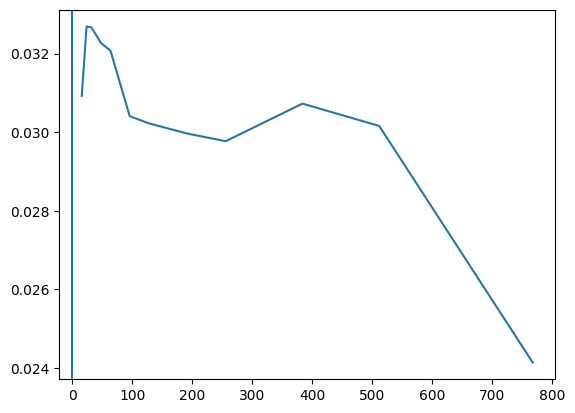

In [19]:
ax = pd.Series(svd_results).plot()
ax.axvline()

In [20]:
best_svd_rank = pd.Series(svd_results).idxmax()

In [23]:
best_config = {'rank': best_svd_rank}
item_factors = build_svd_model(best_config, training_final, data_description_source)
scores = svd_model_scoring(item_factors, testset_final, data_description_source)
recs = topn_recommendations(scores, topn=topn)

In [24]:
recs

array([[ 194,  222,  206, ...,  750,  509,  390],
       [ 610,  551, 1361, ...,  762,  361,  228],
       [  62,  376,  537, ...,  284,  768,  860],
       ...,
       [ 569,  392,   19, ...,  780,  209, 2489],
       [ 983,  965,  973, ..., 1330, 1071, 1520],
       [ 671,  410,  667, ...,  229, 1487,  225]])

In [18]:
save_solution(recs, test_users_index, data_index_source['items'], '50pt.csv')

NameError: name 'recs' is not defined

# 75 pts baseline

### grid-search

In [21]:
scalings = [0.2, 0.4, 0.6, 0.8, 1]
ranks = [b*2**n for n in range(3, 9) for b in [2, 3]]
ranks
ranks

[16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [22]:
def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn=20):
    max_rank = max(ranks)
    config = {'rank': max_rank}
    results = {}
    for scaling in tqdm(scalings):
        config['scaling'] = scaling
        item_factors, *rest = build_ssvd_model(config, training, data_description)
        for rank in ranks:
            item_factors_trunc = item_factors[:, :rank]
            scores = ssvd_model_scoring((item_factors_trunc, )+tuple(rest), testset, data_description)
            recs = topn_recommendations(scores, topn=topn)
            results[(rank, scaling)] = evaluate(recs, holdout, data_description)
    return results

def build_ssvd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    scaled_matrix, scaling_weights = rescale_matrix(source_matrix, config['scaling'])
    _, _, vt = svds(scaled_matrix, k=config['rank'], return_singular_vectors='vh')
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, scaling_weights

def rescale_matrix(matrix, scaling_factor):
    frequencies = matrix.getnnz(axis=0)
    scaling_weights = np.power(frequencies, 0.5*(scaling_factor - 1))
    return matrix.dot(diags(scaling_weights)), scaling_weights

def ssvd_model_scoring(params, data, data_description):
    item_factors , scaling_weights = params
    source_matrix = generate_interactions_matrix(data, data_description, rebase_users=True)
    scores = source_matrix.dot(item_factors) @ item_factors.T
    
    downvote_seen_items(scores, data, data_description)
    return scores

In [ ]:
ssvd_results = ssvd_grid_search(
                ranks, scalings, training, testset, holdout, data_description, topn=20)

### best model

In [ ]:
ssvd_results

In [31]:
ssvd_results

{(16, 0.2): 0.02596740948070105,
 (24, 0.2): 0.026063526745838957,
 (32, 0.2): 0.026953049031973538,
 (48, 0.2): 0.028340997670290052,
 (64, 0.2): 0.029905426656168053,
 (96, 0.2): 0.030859063243602665,
 (128, 0.2): 0.032470410375677786,
 (192, 0.2): 0.03370478698716887,
 (256, 0.2): 0.03504648910998056,
 (384, 0.2): 0.0373927967277285,
 (512, 0.2): 0.036793798833682535,
 (768, 0.2): 0.037659642119809905,
 (16, 0.4): 0.0283891412884655,
 (24, 0.4): 0.029943525646962756,
 (32, 0.4): 0.03030347807987867,
 (48, 0.4): 0.03231942323575544,
 (64, 0.4): 0.03310366082123165,
 (96, 0.4): 0.03369873435017784,
 (128, 0.4): 0.03606346576711637,
 (192, 0.4): 0.036246704993122346,
 (256, 0.4): 0.0373451141535813,
 (384, 0.4): 0.03816437774381299,
 (512, 0.4): 0.03575186907124709,
 (768, 0.4): 0.03482258774408832,
 (16, 0.6): 0.02895512864097637,
 (24, 0.6): 0.028735810974807555,
 (32, 0.6): 0.033829203450473036,
 (48, 0.6): 0.03369366404851882,
 (64, 0.6): 0.034761098274177255,
 (96, 0.6): 0.0347668

In [32]:
best_ssvd_rank = pd.Series(ssvd_results).idxmax()

In [33]:
best_ssvd_rank

(384, 0.4)

In [50]:
best_config = {'rank': best_ssvd_rank[0], 'scaling': best_ssvd_rank[0]}
ssvd_params = build_ssvd_model(best_config, training_final, data_description_source)
sscores = ssvd_model_scoring(ssvd_params, testset_final, data_description_source)
srecs = topn_recommendations(sscores, topn=topn)

In [51]:
save_solution(srecs, test_users_index, data_index_source['items'], '256041.csv')